In [17]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
from itertools import combinations
  
# Fetch dataset
W = fetch_ucirepo(id = 17)

# Data (features and targets as pandas DataFrames)
X = W.data.features
y = W.data.targets

In [18]:
print("Feature space dimensions:", X.shape)

# Optional: explicitly print the number of samples and features
n_samples, n_features = X.shape
print("Number of samples:", n_samples)
print("Number of features:", n_features)

Feature space dimensions: (569, 30)
Number of samples: 569
Number of features: 30


In [19]:
from sklearn.decomposition import PCA


In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

c:\Users\afons\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [22]:
from metric_learn import LMNN, NCA, ITML_Supervised
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
y_train = np.ravel(y_train)  # Convert to shape (n_samples,)
y_test = np.ravel(y_test)

In [23]:
import warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import LMNN
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def evaluate_lmnn(X_train, y_train, number_components):   

    best_acurracy = 0
    best_lambda = None

    # Setting 5-Fold cross validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    lambdas = np.linspace(0, 1, 20)

    results = []

    # Performing cross-validation on the training data
    for reg in lambdas:

        fold_accuracies = []  
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            
            # Spliting data into current training and validation set for this fold
            X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
            y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
            lmnn = LMNN(k=7, n_components=number_components, max_iter=500,learn_rate=1e-6, regularization=reg)
            lmnn.fit(X_train_cv, y_train_cv)

            # Transforming data
            X_train_lmnn = lmnn.transform(X_train_cv)
            X_val_lmnn = lmnn.transform(X_val_cv)

            # Training kNN on the transformed data
            knn = KNeighborsClassifier(n_neighbors=7)
            knn.fit(X_train_lmnn, y_train_cv)

            # Prediction on the validation set
            y_pred = knn.predict(X_val_lmnn)
            acc = accuracy_score(y_val_cv, y_pred)
            fold_accuracies.append(acc)  # Store fold accuracy

        # Calculating average accuracy across the folds for this lambda
        mean_acc = np.mean(fold_accuracies)
        results.append((reg, mean_acc))  

        if(mean_acc > best_acurracy):
            best_acurracy = mean_acc
            best_lambda = reg

    # Plot of the results
    lambdas, accuracies = zip(*results)
    plt.figure(figsize=(8, 6))
    plt.plot(lambdas, accuracies, marker='o', linestyle='-', color='b')
    plt.title(f'Cross-Validation Results with {number_components} Principal Components', fontsize=14)
    plt.xlabel('Lambda', fontsize=12)
    plt.ylabel('Mean Accuracy', fontsize=12)
    plt.grid(True)
    plt.show()

    return best_lambda,best_acurracy


In [11]:
def evaluate_itml(X_train, y_train):   
    from numpy.linalg import LinAlgError
    best_acurracy = 0
    best_gamma = None

    # Setting 5-Fold cross validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    gammas = np.logspace(-3, 3, 20)

    results = []

    # Performing cross-validation on the training data
    for gam in gammas:
        
        fold_accuracies = []  

        for train_idx, val_idx in cv.split(X_train, y_train):
            
            # Spliting data into current training and validation set for this fold
            X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
            y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
            
            try:
                itml = ITML_Supervised(gamma=gam,random_state=42) 
                itml.fit(X_train_cv, y_train_cv)
                X_train_itml = itml.transform(X_train_cv)
                X_val_itml = itml.transform(X_val_cv)
            except LinAlgError:
                continue

            # Training kNN on the transformed data
            knn = KNeighborsClassifier(n_neighbors=3)
            knn.fit(X_train_itml, y_train_cv)

            # Prediction on the validation set
            y_pred = knn.predict(X_val_itml)
            acc = accuracy_score(y_val_cv, y_pred)
            fold_accuracies.append(acc)  # Store fold accuracy

        # Calculating average accuracy across the folds for this gamma
        mean_acc = np.mean(fold_accuracies)
        results.append((gam, mean_acc))  

        if(mean_acc > best_acurracy):
            best_acurracy = mean_acc
            best_gamma = gam

    # Plot of the results
    gammas, accuracies = zip(*results)
    plt.figure(figsize=(8, 6))
    plt.plot(gammas, accuracies, marker='o', linestyle='-', color='b')
    plt.title(f'Cross-Validation Results', fontsize=14)
    plt.xlabel('Gamma', fontsize=12)
    plt.ylabel('Mean Accuracy', fontsize=12)
    plt.grid(True)
    plt.show()

    return best_gamma,best_acurracy


In [12]:
def evaluate_nca(X_train, y_train,number_components):   

    best_acurracy = 0
    best_k = None

    # Setting 5-Fold cross validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    Neighbours = [1,2,3,4,5,6,7,8,9,10]


    # Performing cross-validation on the training data
    for N_Neighbours in Neighbours:
        
        fold_accuracies = []  

        for train_idx, val_idx in cv.split(X_train, y_train):
            
            # Spliting data into current training and validation set for this fold
            X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
            y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
            
            #Transforming Data - inner and outer loops can be interchanged

            nca = NCA(n_components=number_components)
            nca.fit(X_train_cv,y_train_cv)
            X_train_nca = nca.transform(X_train_cv)
            X_val_nca = nca.transform(X_val_cv)
            

            # Training kNN on the transformed data
            knn = KNeighborsClassifier(n_neighbors=N_Neighbours)
            knn.fit(X_train_nca, y_train_cv)

            # Prediction on the validation set
            y_pred = knn.predict(X_val_nca)
            acc = accuracy_score(y_val_cv, y_pred)
            fold_accuracies.append(acc)  # Store fold accuracy

        # Calculating average accuracy across the folds for this gamma
        mean_acc = np.mean(fold_accuracies)
          
        if(mean_acc > best_acurracy):
            best_acurracy = mean_acc
            best_k = N_Neighbours

    return best_k


In [26]:
def plotwithpca(X, y,title):
    pca = PCA(n_components=2,random_state=42)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Class Labels")
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

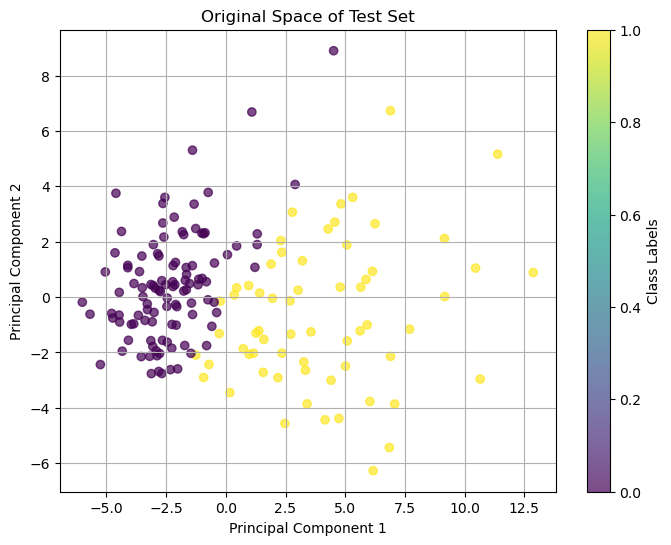

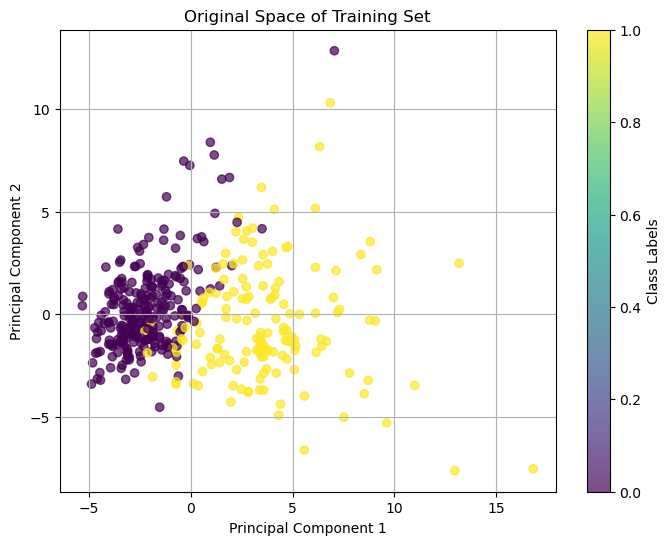

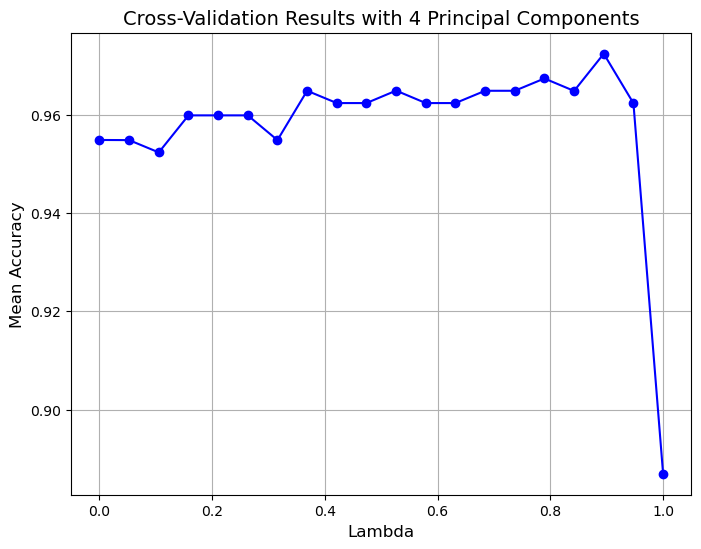

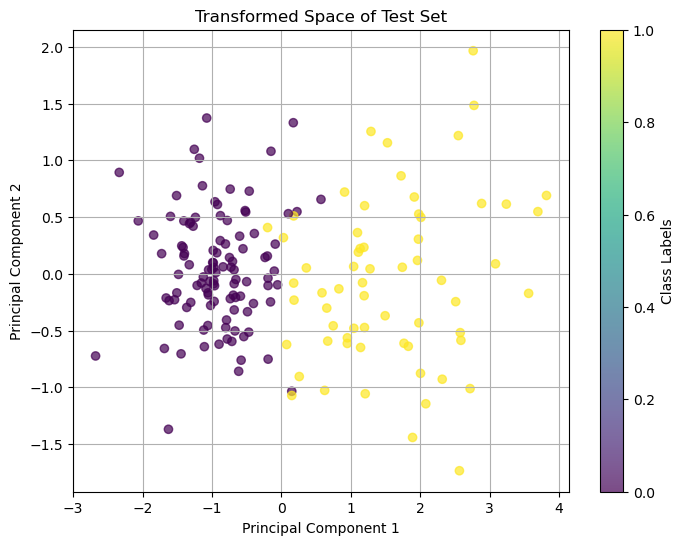

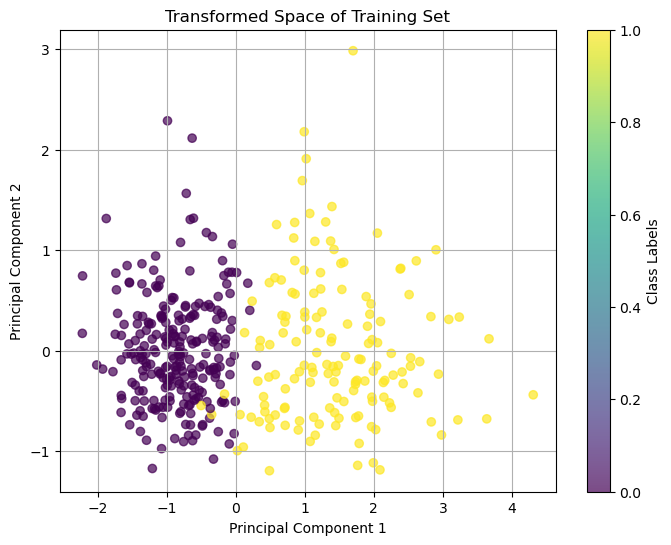

Original Accuracy: 0.95906
Best Lambda: 0.895
Training Acurracy: 0.972
LMNN Accuracy with 4 Principal Components: 0.965


In [30]:
# k-NN Classifier
knn = KNeighborsClassifier(n_neighbors=7)

# Evaluating k-NN on original data
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)


Numberofcomponents = [4]

Acurracies = []

plotwithpca(X_test,y_test,"Original Space of Test Set")
plotwithpca(X_train,y_train,"Original Space of Training Set")


for number_components in Numberofcomponents:

    # Calculating best_Lambda
    best_lambda,best_acurracy = evaluate_lmnn(X_train,y_train,number_components)

    #Transforming Data
    lmnn = LMNN(n_neighbors = 7,n_components= number_components,learn_rate=1e-6, regularization=best_lambda)
    lmnn.fit(X_train, y_train)
    X_train_lmnn = lmnn.transform(X_train)
    X_test_lmnn = lmnn.transform(X_test)

    plotwithpca(X_test_lmnn,y_test,"Transformed Space of Test Set")
    plotwithpca(X_train_lmnn,y_train,"Transformed Space of Training Set")
    
    # LMNN Evaluation
    knn.fit(X_train_lmnn, y_train)
    y_pred_lmnn = knn.predict(X_test_lmnn)
    lmnn_acc = accuracy_score(y_test, y_pred_lmnn)

    Acurracies.append((lmnn_acc,number_components,best_lambda))
    

print(f"Original Accuracy: {acc:.5f}")

for acurracy,number_components,best_lambda in  Acurracies:
    print(f"Best Lambda: {best_lambda:.3f}")
    print(f"Training Acurracy: {best_acurracy:.3f}")
    print(f"LMNN Accuracy with {number_components} Principal Components: {acurracy:.3f}")


c:\Users\afons\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\afons\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


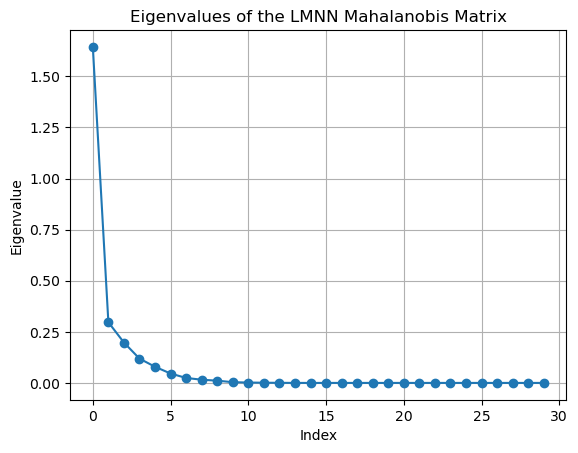

First Eigenvalue: 1.644+0.000j
[ 8.88927632e-02+0.00000000e+00j  1.79724089e-01+0.00000000e+00j
 -6.72390271e-02+0.00000000e+00j -8.84942447e-02+0.00000000e+00j
 -1.73642359e-02+0.00000000e+00j  2.21693501e-01+0.00000000e+00j
 -3.14886949e-03+0.00000000e+00j -2.23232046e-01+0.00000000e+00j
 -1.45127055e-01+0.00000000e+00j -2.51310110e-01+0.00000000e+00j
 -3.84015116e-02+0.00000000e+00j  8.98009965e-02+0.00000000e+00j
 -1.28828941e-01+0.00000000e+00j  5.25506876e-02+0.00000000e+00j
 -2.37576174e-01-9.95098987e-03j -2.37576174e-01+9.95098987e-03j
  1.35630243e-04-9.30521576e-05j  1.35630243e-04+9.30521576e-05j
 -1.42486355e-01+1.47329159e-01j -1.42486355e-01-1.47329159e-01j
 -3.73601322e-02+0.00000000e+00j -6.62049663e-02+0.00000000e+00j
  1.66538040e-01+0.00000000e+00j -1.09537613e-01+0.00000000e+00j
 -3.87263492e-02+8.00517038e-03j -3.87263492e-02-8.00517038e-03j
 -3.54627924e-02+0.00000000e+00j -5.08727458e-02+8.44848086e-03j
 -5.08727458e-02-8.44848086e-03j -8.07570843e-03+0.00000000

In [28]:

lmnn = LMNN(n_neighbors = 3,n_components=13,learn_rate=1e-6, regularization=0.368)
lmnn.fit(X_test,y_test)
M = lmnn.get_mahalanobis_matrix()
eigenvalues, eigenvectors = np.linalg.eig(M)
plt.plot(sorted(eigenvalues, reverse=True), marker='o')
plt.title('Eigenvalues of the LMNN Mahalanobis Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()


pairs = list(zip(eigenvalues,eigenvectors))
sorted_pairs = sorted(pairs,key=lambda x : -1*abs(x[0])) 

fst_eigenvalue, fst_eigenvector = sorted_pairs[0]
snd_eigenvalue, snd_eigenvector = sorted_pairs[1]

print(f"First Eigenvalue: {fst_eigenvalue:.3f}")
print(fst_eigenvector)
print(f"Second Eigenvalue: {snd_eigenvalue:.3f}")
print(snd_eigenvector)



# See eigenvectors corresponding to highest eigenvalues to see possible dominance of some features




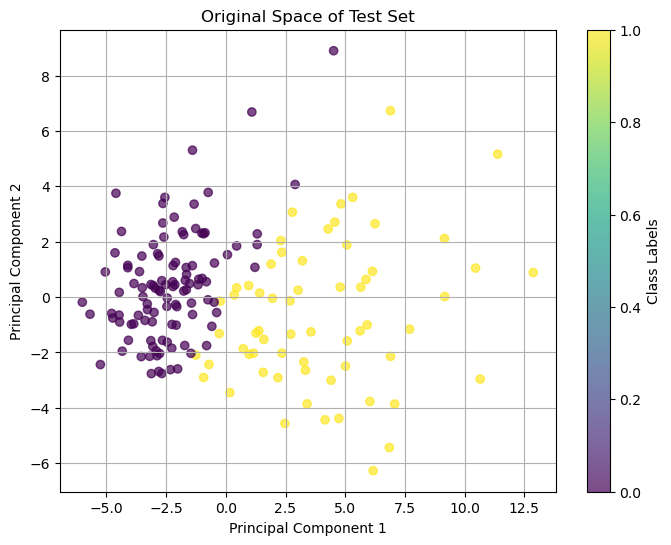

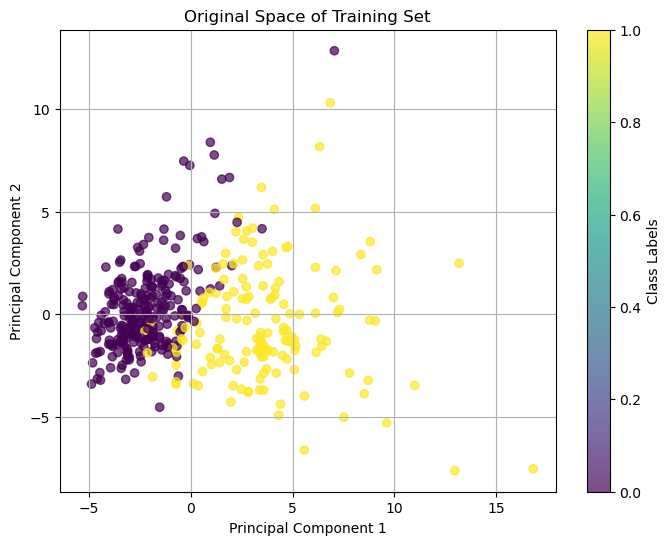

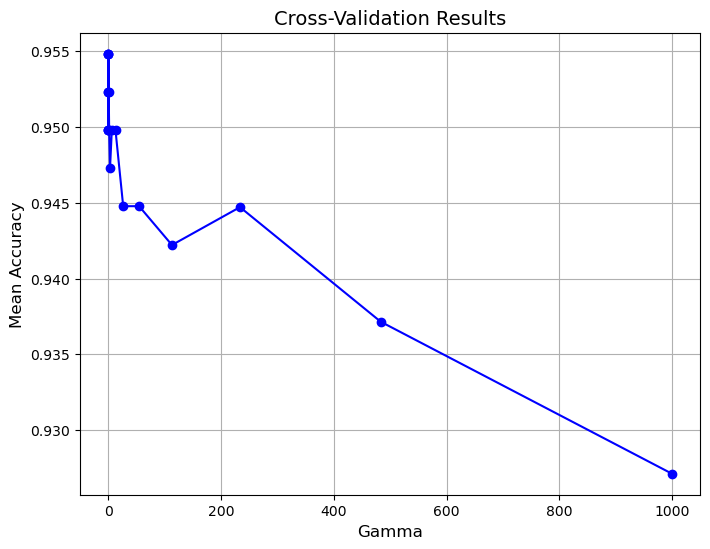

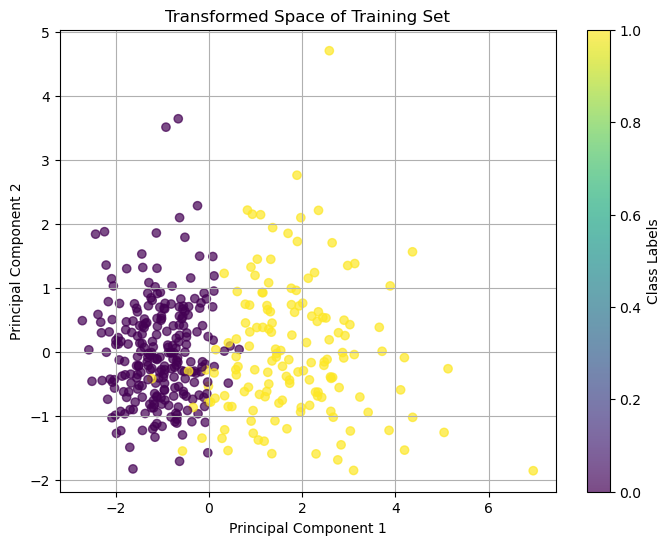

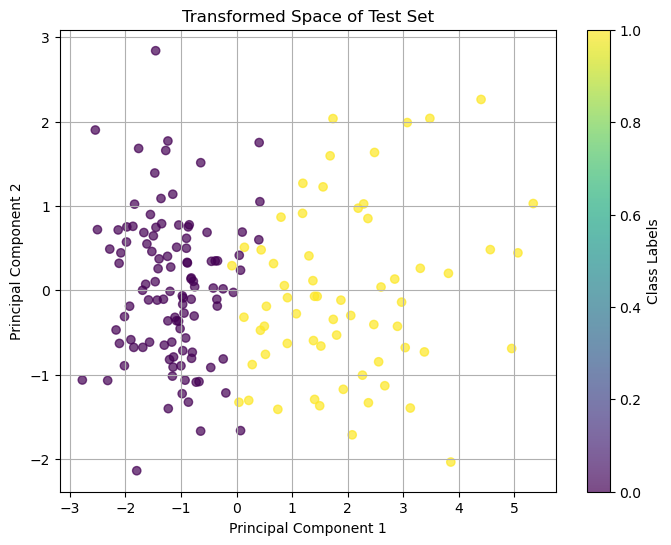

Original Accuracy: 0.95322
Best Gamma: 0.038
Accuracy Training: 0.955
ITML Accuracy with 5 Principal Components: 0.965


In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)

# Evaluating k-NN on the original data
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)

Numberofcomponents = [4]
Acurracies = []

# Plotting original spaces
plotwithpca(X_test, y_test, "Original Space of Test Set")
plotwithpca(X_train, y_train, "Original Space of Training Set")

for number_components in Numberofcomponents:
    # Applying PCA
    pca = PCA(n_components=number_components)
    X_aux_train = pca.fit_transform(X_train)
    X_aux_test = pca.transform(X_test)

    # Evaluate ITML in the PCA space
    best_gamma, best_accuracy = evaluate_itml(X_aux_train, y_train)

    # Apply ITML with the best gamma
    itml = ITML_Supervised(gamma=best_gamma, random_state=42)
    itml.fit(X_aux_train, y_train)
    X_train_itml = itml.transform(X_aux_train)
    X_test_itml = itml.transform(X_aux_test)

    # Plot Transformed Spaces
    plotwithpca(X_train_itml, y_train, "Transformed Space of Training Set")
    plotwithpca(X_test_itml, y_test, "Transformed Space of Test Set")

    # Evaluate ITML-transformed space
    knn.fit(X_train_itml, y_train)
    y_pred_itml = knn.predict(X_test_itml)
    itml_acc = accuracy_score(y_test, y_pred_itml)

    Acurracies.append((itml_acc, number_components, best_gamma))

# Report Results
print(f"Original Accuracy: {acc:.5f}")
for accuracy, number_components, best_gamma in Acurracies:
    print(f"Best Gamma: {best_gamma:.3f}")
    print(f"Accuracy Training: {best_accuracy:.3f}")
    print(f"ITML Accuracy with {number_components} Principal Components: {accuracy:.3f}")


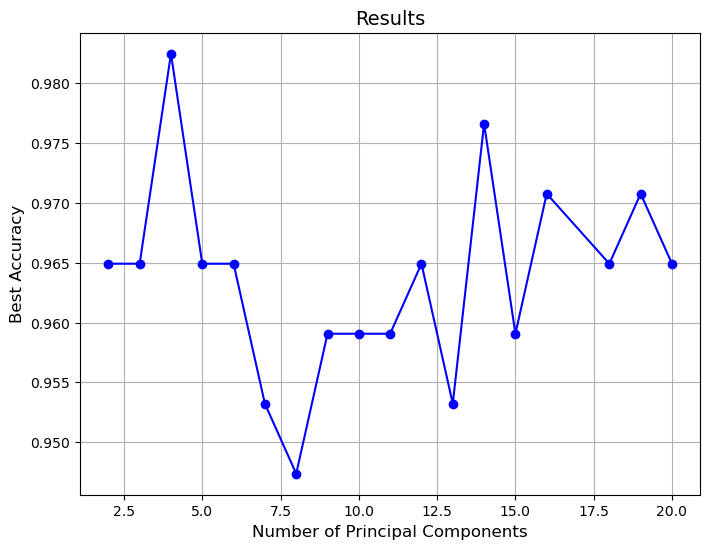

Original Accuracy: 0.95906
Best Accuracy with 4 Principal Components: 0.98246
Associated Number of Neighbours in KNN Evaluation: 7


In [ ]:

Numberofcomponents = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,20]

Acurracies = []

best_acurracy = 0
components_max_acc = None
number_neighbours = None

#plotwithpca(X_test,y_test,"Original Space of Test Set")
#plotwithpca(X_train,y_train,"Original Space of Training Set")

for number_components in Numberofcomponents:

    #Tranforming Data
    best_k= evaluate_nca(X_train,y_train,number_components)
    nca = NCA(n_components=number_components)
    X_aux_train = X_train
    X_aux_test = X_test
    nca.fit(X_aux_train, y_train)
    X_train_nca = nca.transform(X_aux_train)
    X_test_nca = nca.transform(X_aux_test)

    #plotwithpca(X_train_nca,y_train,"Transformed Space of Training Set")
    #plotwithpca(X_test_nca,y_test,"Transformed Space of Test Set")

    # k-NN Classifier
    knn = KNeighborsClassifier(n_neighbors=best_k)
    
    # NCA Evaluation
    knn.fit(X_train_nca, y_train)
    y_pred_nca = knn.predict(X_test_nca)
    nca_acc = accuracy_score(y_test, y_pred_nca)

    Acurracies.append((number_components,nca_acc))  

    if(nca_acc > best_acurracy):
        best_acurracy = nca_acc
        components_max_acc = number_components
        number_neighbours = best_k

      

# Plot of the results
x, y = zip(*Acurracies)
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.title(f'Results', fontsize=14)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Best Accuracy', fontsize=12)
plt.grid(True)
plt.show()

# k-NN Classifier
best_knn = KNeighborsClassifier(n_neighbors=number_neighbours)

# Evaluating k-NN on Original Data
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Original Accuracy: {acc:.5f}")

print(f"Best Accuracy with {components_max_acc} Principal Components: {best_acurracy:.5f}")
print(f"Associated Number of Neighbours in KNN Evaluation: {best_k}")



In [31]:
# Remarks:

# All algorithms perform well with the Wine dataset, which is explained by the small number of samples
# and clear prior division of targets(as in before applying transformation) as seen in Original Space obtained with PCA with 2 princpal components.
# When the transformation is applied, no notable difference is seen,except maybe a more clear distinction between clusters.
# All of this results in no exceptional improvement when compared to applying KNN with original data and Euclidean Distance.

# With regard to the other dataset: There is a somewhat clear distinction between targets (Sas seen in Original Space), but ,this time, 
# due to the large number of samples (when compared to the Wine Data set) combined with a non-negligible noisy region , around the middle,
# no large improvements when using LMNN and ITML are seen. The same thing cannot be said about NCA;
# This is due, we think, to one main reason: our specific choices of hysperparemeters for the models;
# While in all of them we performed PCA, only in NCA we varied the number of neighbours used in the fit of KNN on the training set, which makes us
# conclude, based on the results we got ,the visualization of the data and previous considerations
# that a better classification can be achieved, if we prioritize a higher
# number of neighbours both in the process of classification,given by KNN and in the process of obtaining the Mahalanobis distance in the case of
# LMNN (similarity, dissimilarity pairs)

#(TEST) - 4 Pirncipal components (or lower?) seems to be the ideal amount(based on NCA) and with high number of neighbours - the performance
# increases for ITML and LMNN;S




In [29]:
# LMNN
lmnn = LMNN(k=3, learn_rate=1e-6,regularization=0.5)
lmnn.fit(X_train, y_train)
X_train_lmnn = lmnn.transform(X_train)
X_test_lmnn = lmnn.transform(X_test)

In [8]:
# NCA
nca = NCA(max_iter=50)
nca.fit(X_train, y_train)
X_train_nca = nca.transform(X_train)
X_test_nca = nca.transform(X_test)

In [32]:
# ITML
itml = ITML_Supervised()
itml.fit(X_train, y_train)
# Transform the training and testing data (not pairs anymore)
X_train_itml = itml.transform(X_train)
X_test_itml = itml.transform(X_test)

In [34]:
# k-NN Classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Evaluate k-NN on original data
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)

# Evaluate LMNN
knn.fit(X_train_lmnn, y_train)
y_pred_lmnn = knn.predict(X_test_lmnn)
lmnn_acc = accuracy_score(y_test, y_pred_lmnn)

# Evaluate NCA
#knn.fit(X_train_nca, y_train)
#y_pred_nca = knn.predict(X_test_nca)
#nca_acc = accuracy_score(y_test, y_pred_nca)

# Evaluate ITML
knn.fit(X_train_itml, y_train)
y_pred_itml = knn.predict(X_test_itml)
itml_acc = accuracy_score(y_test, y_pred_itml)

print(f"Original Accuracy: {acc:.2f}")
print(f"LMNN Accuracy: {lmnn_acc:.2f}")
#print(f"NCA Accuracy: {nca_acc:.2f}")
print(f"ITML Accuracy: {itml_acc:.2f}")


Original Accuracy: 0.96
LMNN Accuracy: 0.98
ITML Accuracy: 0.98


## Generate Synthetic Data that shows difference learning

In [41]:
from sklearn.datasets import make_classification


In [42]:
X, y = make_classification(n_samples=200, n_features=2, n_classes=2, n_informative=2, n_redundant=0, random_state=42)
X[:, 1] *= 1000

In [43]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train = np.ravel(y_train)  # Convert to shape (n_samples,)
y_test = np.ravel(y_test)

In [45]:
# Generate pairs and labels for the training data
pairs_train, labels_train = create_pairs(X_train, y_train)

In [46]:
# LMNN
lmnn = LMNN(k=3, learn_rate=1e-6)
lmnn.fit(X_train, y_train)
X_train_lmnn = lmnn.transform(X_train)
X_test_lmnn = lmnn.transform(X_test)

# NCA
nca = NCA(max_iter=100)
nca.fit(X_train, y_train)
X_train_nca = nca.transform(X_train)
X_test_nca = nca.transform(X_test)

# ITML
itml = ITML()
itml.fit(pairs_train, labels_train)
# Transform the training and testing data (not pairs anymore)
X_train_itml = itml.transform(X_train)
X_test_itml = itml.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/metric_learn/lmnn.py:140: FutureWarning: "num_chunks" parameter has been renamed to "n_chunks". It has been deprecated in version 0.6.3 and will be removed in 0.7.0
  warnings.warn('"num_chunks" parameter has been renamed to'


In [47]:
# k-NN Classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Evaluate k-NN on original data
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)

# Evaluate LMNN
knn.fit(X_train_lmnn, y_train)
y_pred_lmnn = knn.predict(X_test_lmnn)
lmnn_acc = accuracy_score(y_test, y_pred_lmnn)

# Evaluate NCA
knn.fit(X_train_nca, y_train)
y_pred_nca = knn.predict(X_test_nca)
nca_acc = accuracy_score(y_test, y_pred_nca)

# Evaluate ITML
knn.fit(X_train_itml, y_train)
y_pred_itml = knn.predict(X_test_itml)
itml_acc = accuracy_score(y_test, y_pred_itml)

print(f"Original Accuracy: {acc:.2f}")
print(f"LMNN Accuracy: {lmnn_acc:.2f}")
print(f"NCA Accuracy: {nca_acc:.2f}")
print(f"ITML Accuracy: {itml_acc:.2f}")

Original Accuracy: 0.43
LMNN Accuracy: 0.85
NCA Accuracy: 0.85
ITML Accuracy: 0.83
